In [1]:
import numpy as np
import matplotlib.pyplot as plt
from bandit import Bandits_one, Bandits_final

In [2]:
np.random.seed(123)

In [3]:
def decaying_epsilon_greedy(mab, num_steps=5000, epsilon_start=1.0, epsilon_decay=0.999, epsilon_min=0.001, alpha=-1):
    k = mab.k  # number of actions
    Q = np.zeros(k)  # estimated values for each action
    N = np.zeros(k)  # number of times each action was taken

    rewards = []
    optimal_action_counts = np.zeros(num_steps)

    epsilon = epsilon_start

    for episode in range(num_steps):
        if np.random.rand() < epsilon:
            action = np.random.randint(0, k)  # exploration
        else:
            action = np.argmax(Q)  # exploitation

        _, reward, _, _, _ = mab.step(action)

        rewards.append(reward)

        # check if the action was optimal
        optimal_action = mab.get_optimal_action()
        if action == optimal_action:
            optimal_action_counts[episode] = 1  # mark as optimal

        N[action] += 1
        # if alpha is -1, the step size is dynamic, averaging the rewards;
        # with constant alpha, each reward has equal weight, with increased response to recent rewards.
        step_size = 1 / N[action] if alpha == -1 else alpha
        Q[action] += step_size * (reward - Q[action])

        epsilon = max(epsilon_min, epsilon_decay * epsilon)

    percent_optimal_actions = np.cumsum(optimal_action_counts) / np.arange(1, num_steps + 1)

    return rewards, percent_optimal_actions

In [4]:
def run_bandit_simulation(num_runs=500, num_steps=5000, alpha=-1):
    avg_reward = np.zeros(num_steps)
    avg_optimal_actions = np.zeros(num_steps)

    for run in range(num_runs):
        mab = Bandits_final()
        rewards, percent_optimal_actions = decaying_epsilon_greedy(mab, alpha=alpha)
        avg_reward += rewards
        avg_optimal_actions += percent_optimal_actions

    avg_reward /= num_runs
    avg_optimal_actions /= num_runs
    return avg_reward, avg_optimal_actions

In [5]:
step_sizes = [-1, 0.01, 0.25, 0.5]
simulation_results = [run_bandit_simulation(alpha=step_size) for step_size in step_sizes]

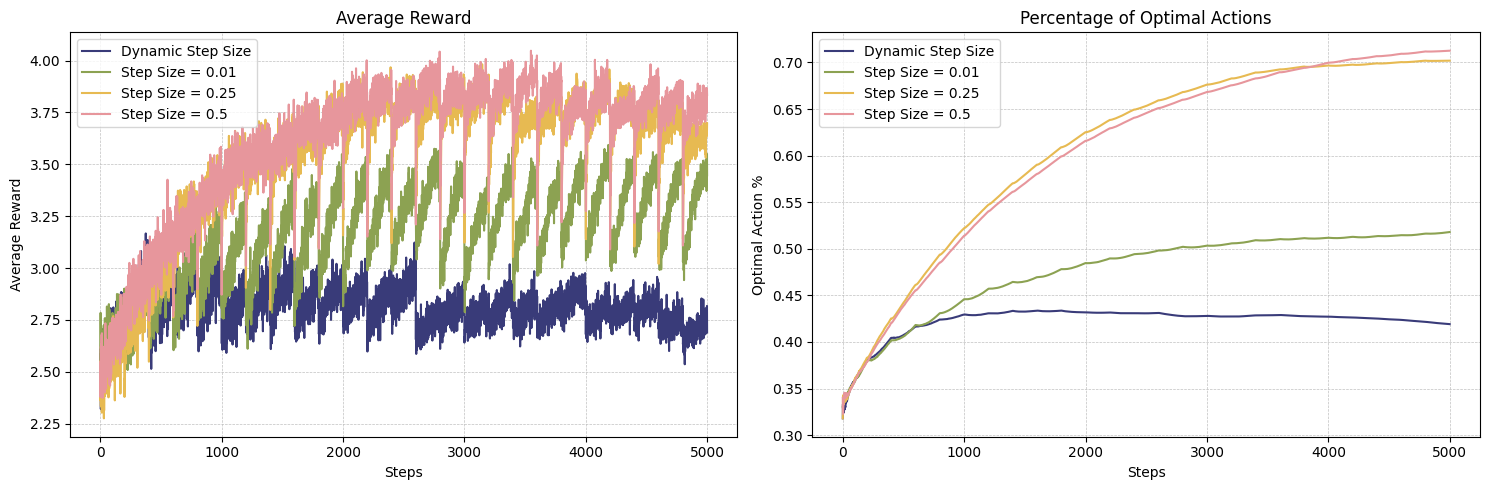

In [6]:
cmap = plt.get_cmap("tab20b")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

for i, step_size in enumerate(step_sizes):
    label = "Dynamic Step Size" if step_size == -1 else f"Step Size = {step_size}"
    ax1.plot(simulation_results[i][0], label=label, color=cmap(i / len(step_sizes)))
    ax2.plot(simulation_results[i][1], label=label, color=cmap(i / len(step_sizes)))

ax1.set_title("Average Reward")
ax1.set_ylabel("Average Reward")
ax1.set_xlabel("Steps")
ax1.grid(color='silver', linestyle="--", linewidth=0.5)
ax1.legend()

ax2.set_title("Percentage of Optimal Actions")
ax2.set_ylabel("Optimal Action %")
ax2.set_xlabel("Steps")
ax2.grid(color='silver', linestyle='--', linewidth=0.5)
ax2.legend()

plt.tight_layout()
plt.show()